<a href="https://colab.research.google.com/github/dadkins20/machine-learning/blob/master/CSE676_Project1A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [3]:
(train_images, _), (_,_) = tf.keras.datasets.cifar10.load_data()

def get_real_data(X, batch_size):
    randoms = np.random.randint(0,X.shape[0], batch_size)
    real_images = train_images[randoms]
    real_images = (real_images) / 255
    return np.array(real_images)
  
X = get_real_data(X=train_images,batch_size=64)
X.shape, X.min(), X.max()

170500096/170498071 [==============================] - 2s 0us/step


((64, 32, 32, 3), 0.0, 1.0)

In [0]:
def get_generator_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(4*4*256, input_shape=(100,)))
    model.add(tf.keras.layers.Reshape((4,4,256)))
    
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
        
    model.add(tf.keras.layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same'))
    
    model.add(tf.keras.layers.Activation('softmax'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    #model.summary()

    return model
  
generator = get_generator_model()

In [0]:
def generate_images(n):
  noise = tf.random.normal([1, 100*n])
  noise = tf.reshape(noise, [n, 100])
  
#   fake_image = generator(noise, training=False)
#   return fake_image
  return noise


# img = generate_images(10)
# #print(img.shape)
# plt.figure(figsize=(32,32))
# print(img[0])
# for x in range(10):
#   #print(img[x])
#   plt.subplot(10, 10, x+1)
#   plt.imshow(img[x])
#   plt.axis('off')

In [0]:
def get_discriminator_model():
    model = tf.keras.Sequential()
        
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides = (2,2), padding='same', input_shape=(32,32,3)))
    
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(2,2), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.3))
    
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation='softmax'))
    
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))
    
    #model.summary()
     
    return model
  
discriminator = get_discriminator_model()

In [7]:
def get_gan_model(gm, dm, inpImages=[]):
  
  generator_input = tf.keras.Input((100,))
    
  generator_output = gm(generator_input)
  
  discriminator_output = dm(generator_output, training=False)
   
  model = tf.keras.Model(inputs=generator_input, outputs=discriminator_output)
  
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  
  model.summary()
  
  return model


gan = get_gan_model(generator, discriminator)
    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         1995651   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1556609   
Total params: 3,552,260
Trainable params: 3,549,188
Non-trainable params: 3,072
_________________________________________________________________


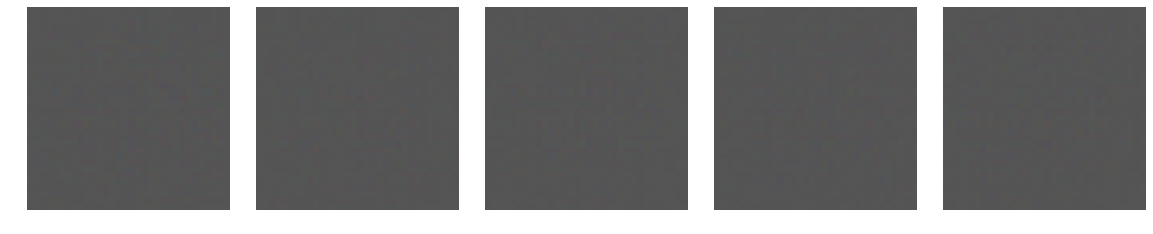

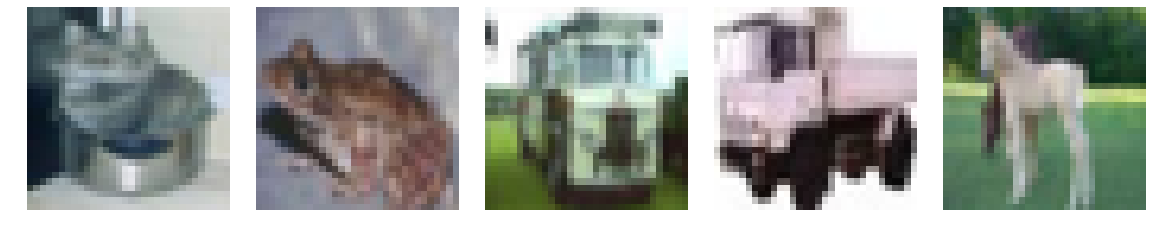

In [8]:
#Display output
import matplotlib.pyplot as plt
def show_images(t):
  if t == 'real':
    preds = get_real_data(train_images,5)
  else:
    preds = generator(generate_images(5), training=False)
  plt.figure(figsize=(32,32))
  for i in range(preds.shape[0]):
      plt.subplot(10, 10, i+1)
      plt.imshow(preds[i])
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.tight_layout()
  plt.savefig('20')

show_images('fake')
show_images('real')


In [0]:
def train(epochs,batch_size): # first is epochs, second is batch size
  real_labels = np.ones((batch_size,1))
  fake_labels = np.zeros((batch_size,1))
  for i in range(epochs):
    
    print("Starting Epoch (", i, ",", epochs, ")")
    
    for j in range(batch_size):
            
      real_images = get_real_data(train_images,batch_size)
      fake_images = generator.predict(generate_images(batch_size), batch_size=batch_size)
            
      combined_images = np.concatenate([real_images, fake_images])
      combined_labels = np.concatenate([real_labels, fake_labels])
      
      discriminator.trainable = True
      discriminator.train_on_batch(combined_images, combined_labels)
      
      more_fake_images = generate_images(batch_size)
      
      discriminator.trainable = False
      gan.train_on_batch(generate_images(batch_size), real_labels)

In [16]:
import os

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')

TPU address is grpc://10.6.161.170:8470
TPU devices:


In [17]:
session = tf.Session(tpu_address)
session.run(train(1500,64))
  


# train(1500, 64)

show_images('real')
show_images('fake')

Starting Epoch ( 0 , 1500 )
Starting Epoch ( 1 , 1500 )
Starting Epoch ( 2 , 1500 )
Starting Epoch ( 3 , 1500 )
Starting Epoch ( 4 , 1500 )
Starting Epoch ( 5 , 1500 )
Starting Epoch ( 6 , 1500 )
Starting Epoch ( 7 , 1500 )
Starting Epoch ( 8 , 1500 )
Starting Epoch ( 9 , 1500 )
Starting Epoch ( 10 , 1500 )
Starting Epoch ( 11 , 1500 )
Starting Epoch ( 12 , 1500 )
Starting Epoch ( 13 , 1500 )
Starting Epoch ( 14 , 1500 )
Starting Epoch ( 15 , 1500 )
Starting Epoch ( 16 , 1500 )
Starting Epoch ( 17 , 1500 )
Starting Epoch ( 18 , 1500 )
Starting Epoch ( 19 , 1500 )
Starting Epoch ( 20 , 1500 )
Starting Epoch ( 21 , 1500 )
Starting Epoch ( 22 , 1500 )
Starting Epoch ( 23 , 1500 )
Starting Epoch ( 24 , 1500 )
Starting Epoch ( 25 , 1500 )
Starting Epoch ( 26 , 1500 )
Starting Epoch ( 27 , 1500 )
Starting Epoch ( 28 , 1500 )
Starting Epoch ( 29 , 1500 )
Starting Epoch ( 30 , 1500 )
Starting Epoch ( 31 , 1500 )
Starting Epoch ( 32 , 1500 )
Starting Epoch ( 33 , 1500 )
Starting Epoch ( 34 , 15

KeyboardInterrupt: ignored